# Further Ideas: Wasserstein-GAN (WGAN)

In this notebook, we stick to the idea of implementing a GAN that learns how to generate images similar to the MNIST dataset. The goal is to inspect the Wasserstein Distance and the change of results when alternating the modell to a WGAN. Thereby a WGAN was implemented.

In preparation of using the different approach, the recommended documents [1] and [2] were consulted.

| Teammember |                    |
|------------|--------------------|
| 1.         | Nadine Weber       |
| 2.         | Patrick Singer     |


## Introduction
[Wasserstein GANs (WGAN)](https://arxiv.org/pdf/1701.07875.pdf) are an alternative to *classical* GANs. They use a different loss function and prooved to be more stable to hyperparameter selection. While the paper offers a good theoretical introduction and reasoning why they perform better in many cases, [this article](https://wiseodd.github.io/techblog/2017/02/04/wasserstein-gan/) provides a good practical introduction. (*Copied from original notebook*)

### What is the Wasserstein distance?

The Wasserstein distance, or also known as Earth Mover (EM) distance, 
is a metric of comparing the shift between and similarity of different probability distributions.
It shows qualitative information about to what extent distributions are similar to each other, by means of their distance to each other. 
Introducing the term 'work' of shifting rocks from one mountain to another, the Wasserstein-GAN (WGAN) minimizes the work that needs to be spent.

The papers claims that there a two main advantages of WGANs: 
- Improved stability of the optimization and...
- a meaningful loss metric correlating with the generator’s convergence.

Wasserstein-GANs in particular minimize the effects of *Mode Collapsing,* resulting in focusing on a 
similar image space while ignoring the input. [1]

### How to build a Wasserstein-GAN (WGAN)
The algorithm from WCGAN to WGAN is quite similar. The base structure of the normal GAN, implemented in the original task, therefore was used for this model as well. Corresponding to [2], a GAN needs to have these minor changes applied to become a WGAN:
    
1. No log in the loss. The output of D is no longer a probability, hence we do not apply sigmoid at the output of the discriminator
2. Clip the weight of the discriminator. This is necessary because the distance is not a smooth function.
3. Train the discriminator more than the generator
4. Use RMSProp instead of ADAM optimizer
5. Apply lower learning rate

About 1) The important difference between the two models is the ```loss function```. While in the simple GAN a ```log``` function is applied, the WGAN uses a simple ```mean``` function for computing the distances. This is why the discriminator is also being called ```critic```. Instead of the ```sigmoid``` activiation function, a ```linear``` activation function will be used, because the loss function is 'only' a mean function. No more binary cross-entropy with a probability distribution. The WGAN provides simple values.
 
About 2) Because Wasserstein tends to take a longer time computing the mean values and strives to be a non-continuous function, the value space of the optimizer ```RMSprops``` needs to be clipped into a range between -1.0 and 1.0 (parameter c). This is for the critic to be a continuous function.

About 3) While a normal discriminator is updated as often as the generator, the critic in a WGAN is trained more often than the generator. For every X update steps for the critic, there is one update for the generator.

About 4) The optimizer changes from ADAM to RMSProp,  because ADAM uses a ```log``` function.

We chose to implement most of the aspects described in the article. Because we wanted to focus on testing the different loss functions and compare them to our original model, we skipped the clipping of the weights as we felt this step would alter the training too much.

### Code
As the code mostly resembles the original GAN structure, comments were only added in places where we made changes to avoid repitition.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import random

%matplotlib inline

print(f"Tensorflow version: {tf.__version__} | Keras version: {keras.__version__}")
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2023-04-11 19:45:34.619083: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


Tensorflow version: 2.4.1 | Keras version: 2.4.0
Num GPUs Available:  1


2023-04-11 19:45:49.010514: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-04-11 19:45:49.012188: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-04-11 19:45:49.058362: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:06:00.0 name: NVIDIA TITAN Xp computeCapability: 6.1
coreClock: 1.582GHz coreCount: 30 deviceMemorySize: 11.91GiB deviceMemoryBandwidth: 510.07GiB/s
2023-04-11 19:45:49.058394: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-04-11 19:45:49.061318: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-04-11 19:45:49.061356: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2023-

Original dataset: max val = 255 | min val = 0
Normalized dataset: max val = 1.0 | min val = 0.0


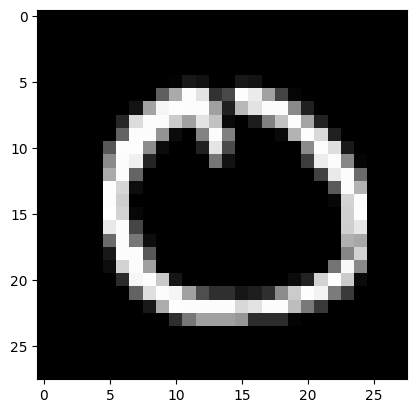

In [2]:
# Load MNIST
(train_x, train_y), (test_x, test_y) = mnist.load_data()

# Normalize dataset
train_x_norm, test_x_norm = train_x/255, test_x/255
print(f"Original dataset: max val = {np.max(train_x)} | min val = {np.min(train_x)}")
print(f"Normalized dataset: max val = {np.max(train_x_norm)} | min val = {np.min(train_x_norm)}")

# Show one example image
plt.imshow(train_x[random.randint(0,len(train_x))], cmap="gray");

In [6]:
# Reshaping dataset (Conv2D wants input = (batch_size, height, width, channels))
x_train_reshaped = train_x_norm.reshape(train_x_norm.shape[0], 28, 28, 1)
x_test_reshaped = test_x_norm.reshape(test_x_norm.shape[0], 28, 28, 1)
print(f"Dataset shape: {x_train_reshaped.shape}")

Dataset shape: (60000, 28, 28, 1)


<h3><font color="blue">Discriminator Model</font></h3>
In the discriminator, the activation of the output layer was changed from sigmoid to linear.


In [7]:
def build_discriminator():
    model = keras.Sequential([
        keras.layers.Conv2D(input_shape=(28, 28, 1), filters=32, kernel_size=5, padding="same", activation=keras.layers.LeakyReLU(alpha=0.2)),
        keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2)),
        keras.layers.Conv2D(filters=64, kernel_size=5, padding="same", activation=keras.layers.LeakyReLU(alpha=0.2)),
        keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(units=1024, activation=keras.layers.LeakyReLU(alpha=0.2)),
        keras.layers.Dense(units=1, activation="linear")
    ])
    
    return model

In [8]:
test_discriminator_model = build_discriminator()
test_discriminator_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
average_pooling2d (AveragePo (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        51264     
_________________________________________________________________
average_pooling2d_1 (Average (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              3212288   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

In [9]:
print(test_discriminator_model.predict(x_test_reshaped[0:1]))

2023-04-11 19:45:52.148645: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-04-11 19:45:52.298013: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2023-04-11 19:45:52.898683: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2023-04-11 19:45:52.993591: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


[[0.04584572]]


In [10]:
from tensorflow.keras.layers import Layer

class CustomUpsample(Layer):
    def __init__(self, size=(2, 2), **kwargs):
        super().__init__(**kwargs)
        self.size = size
    
    def call(self, inputs):
        return tf.image.resize(inputs, size=self.size, method=tf.image.ResizeMethod.BILINEAR)

In [11]:
def build_generator(n, output_dim=28):
    l = (output_dim*2)**2
    
    model = keras.Sequential([
        keras.layers.Dense(input_shape=(n,), units=l, activation="relu"),
        keras.layers.Reshape((output_dim*2, output_dim*2, 1), input_shape=(l,)),
        keras.layers.Conv2D(filters=int(n/2), kernel_size=3, strides=(2, 2), padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        CustomUpsample((output_dim*2+2, output_dim*2+2)),
        keras.layers.Conv2D(filters=int(n/4), kernel_size=3, strides=(2, 2)),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        CustomUpsample((output_dim*2+2, output_dim*2+2)),
        keras.layers.Conv2D(filters=1, kernel_size=3, strides=(2, 2), activation="sigmoid")      
    ])
    
    return model


In [12]:
test_generator_model = build_generator(100, output_dim=28)
test_generator_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 3136)              316736    
_________________________________________________________________
reshape (Reshape)            (None, 56, 56, 1)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 50)        500       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 50)        200       
_________________________________________________________________
re_lu (ReLU)                 (None, 28, 28, 50)        0         
_________________________________________________________________
custom_upsample (CustomUpsam (None, 58, 58, 50)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 25)       

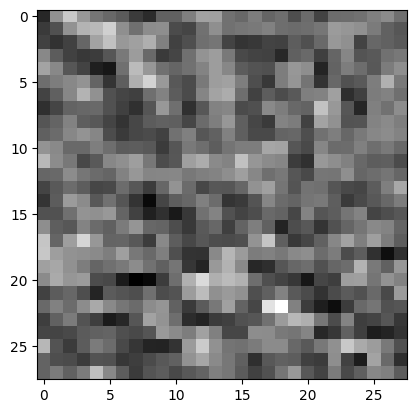

In [13]:
test_out = test_generator_model.predict(([random.random() for _ in range(100)],))
plt.imshow(np.reshape(test_out, (28, 28)), cmap="gray");

<font color="blue"><b>Comment:</b></font> The loss functions were changed to the wasserstein distance.

In [14]:
@tf.function
def calc_discriminator_loss(real_output, fake_output):
    return tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)

@tf.function
def calc_generator_loss(fake_output):
    return -tf.reduce_mean(fake_output)

In [15]:
example_generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
example_discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [16]:
from datetime import datetime
import os
import time

In [17]:
def create_log_folder():
    current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
    log_dir = os.path.join("./tensorboard", current_time)

    if not os.path.exists(log_dir):
        os.makedirs(log_dir)

    file_writer = tf.summary.create_file_writer(log_dir)
    
    return file_writer, log_dir

In [18]:
# Show images of a batch
def show_imgs_of_batch(image_batch):
    fig = plt.figure()

    for i in range(len(image_batch)):
        fig.add_subplot(1, len(image_batch), i+1)
        plt.imshow(image_batch[i], cmap="gray")
        plt.axis('off')
    plt.show()

### Pretraining Functions

In [19]:
def pretrain_step(image_batch, generator_model, discriminator_model, discriminator_optimizer, noise_vector_length=100, show_details=False):
    image_batch = tf.convert_to_tensor(image_batch)   
    
    if show_details:
        show_imgs_of_batch(image_batch)
    
    # Generate fake images
    noise = tf.random.normal([len(image_batch), noise_vector_length])
    fake_img_batch = generator_model(noise, training=False)
    
    if show_details:
        show_imgs_of_batch(fake_img_batch)
    
    # Loss
    with tf.GradientTape(persistent=True) as tape:
        real_img_predictions = discriminator_model(image_batch, training=True)   
        fake_img_predictions = discriminator_model(fake_img_batch, training=True)
        
        if show_details:
            print(f"Real predictions:\n{real_img_predictions}\n"
                  f"Fake predictions:\n{fake_img_predictions}")
        
        loss = calc_discriminator_loss(real_img_predictions, fake_img_predictions)
        
        if show_details:
            print(f"Loss: {loss}")

    # Get gradients
    gradients = tape.gradient(loss, discriminator_model.trainable_variables)
    
    # Apply gradients to weights in model
    discriminator_optimizer.apply_gradients(zip(gradients, discriminator_model.trainable_variables))

    return {"loss": loss.numpy(), 
            "real_img_confidence": tf.reduce_mean(real_img_predictions).numpy(),
            "fake_img_confidence": tf.reduce_mean(fake_img_predictions).numpy()}

In [20]:
def pretraining(batch_size, steps, generator_model, discriminator_model, discriminator_optimizer, train_data=x_train_reshaped):
    step_results = []
    fig = plt.figure(dpi=80)
    batches = [train_data[x:x+batch_size] for x in range(0, len(train_data),batch_size)]
    if len(batches) > steps:
        batches = batches[:steps]
    
    for batch_imgs in batches:
        step_result = pretrain_step(batch_imgs, generator_model, discriminator_model, discriminator_optimizer, show_details=False)
        step_results.append(step_result)
    
    # Plot
    fig.add_subplot(2, 1, 1)
    
    plt.plot([val["loss"] for val in step_results], "b")
    plt.title("Discriminator Pretraining")
    plt.ylabel("Loss")
    plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    
    fig.add_subplot(2, 1, 2)
    plt.plot([val["real_img_confidence"] for val in step_results], "g", label="Real Images")
    plt.plot([val["fake_img_confidence"] for val in step_results], "r", label="Fake Images")
    plt.xlabel("Step")
    plt.ylabel("Confidence") 
    plt.legend()
    plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    
    plt.show()

### Training Functions

In [21]:
def train_step(image_batch, generator_model, discriminator_model, discriminator_optimizer, generator_optimizer, noise_vector_length=100, show_details=False):
    image_batch = tf.convert_to_tensor(image_batch)   
    
    # Loss
    with tf.GradientTape(persistent=True) as tape:
        # Generate fake images
        noise = tf.random.normal([len(image_batch), noise_vector_length])
        fake_img_batch = generator_model(noise, training=False)
        
        # Discriminator prediction for real and fakes
        real_img_predictions = discriminator_model(image_batch, training=True)   
        fake_img_predictions = discriminator_model(fake_img_batch, training=True)
        
        # Losses for both models
        dis_loss = calc_discriminator_loss(real_img_predictions, fake_img_predictions)
        gen_loss = calc_generator_loss(fake_img_predictions)
        
        if show_details:
            print(f"Discriminator Loss: {dis_loss}")
            print(f"Generator Loss: {gen_loss}")
            print(len(fake_img_batch))
            show_imgs_of_batch(fake_img_batch[0:5])
        
    # Get gradients
    dis_gradients = tape.gradient(dis_loss, discriminator_model.trainable_variables)
    gen_gradients = tape.gradient(gen_loss, generator_model.trainable_variables)

    # Apply gradients to weights in model
    discriminator_optimizer.apply_gradients(zip(dis_gradients, discriminator_model.trainable_weights))
    generator_optimizer.apply_gradients(zip(gen_gradients, generator_model.trainable_variables))
    
    return {"discriminator_loss": dis_loss.numpy(),
            "generator_loss": gen_loss.numpy(),
            "sample_images": fake_img_batch[:4]}

In [22]:
def training(batch_size, epochs, generator_model, discriminator_model, discriminator_optimizer, generator_optimizer, train_data=x_train_reshaped, plot_every_x_epochs=10, file_writer=None):
    step_results_list = []
    total_trained_on_images = 0
    total_weight_adjustments = 0
    start_time = time.time()
    
    for epoch in range(1, epochs+1):
        
        # Shuffle new batches
        np.random.shuffle(train_data)
        batches = [train_data[x:x+batch_size] for x in range(0, len(train_data),batch_size)]
        if len(batches[-1]) != batch_size:
            batches = batches[:-1]
        
        # Train one epoch 
        for batch_imgs in batches:
            step_results = train_step(batch_imgs, generator_model, discriminator_model, discriminator_optimizer, generator_optimizer)
            step_results_list.append({"discriminator_loss": step_results["discriminator_loss"], "generator_loss": step_results["generator_loss"]})
            
            total_trained_on_images += len(batch_imgs)
            total_weight_adjustments += 1
            
            # Write to file every 10 steps as described in the task
            if total_weight_adjustments % 10 == 0 and file_writer != None:
                with file_writer.as_default():
                    tf.summary.scalar("generator_loss", step_results['generator_loss'], step=total_weight_adjustments)
                    tf.summary.scalar("discriminator_loss", step_results['discriminator_loss'], step=total_weight_adjustments)
                    for i in range(1, len(step_results["sample_images"])):
                        tf.summary.image(f"sample_img_{i}", step_results["sample_images"][i-1:i], step=total_weight_adjustments)
                

        # Summary
        if epoch % plot_every_x_epochs == 0 or epoch == 1:
                        
            # Print summary
            print(f"Summary after epoch {epoch}\n" +"="*(20+len(str(epoch))))
            print(f"Training progress: {round((epoch/epochs)*100)}%")
            print(f"Time elapsed: {round(time.time() - start_time)} seconds")
            print(f"Current Discriminator Loss: {str(step_results['discriminator_loss'])[:5]}")
            print(f"Current Generator Loss: {str(step_results['generator_loss'])[:5]}")
            print(f"Total trained on images: {total_trained_on_images}")
            print(f"Total weight adjustments: {total_weight_adjustments}")
            
            # Plot summary
            fig = plt.figure(figsize=(8, 3), dpi=80)
            gs = fig.add_gridspec(2,5)
            
            ax1 = fig.add_subplot(gs[:, 0:3])
            ax1.plot([val["discriminator_loss"] for val in step_results_list], "r", label="Discriminator")
            ax1.plot([val["generator_loss"] for val in step_results_list], "g", label="Generator")
            ax1.set_title(f"Training after epoch {epoch}")
            ax1.set_xlabel("Step")
            ax1.set_ylabel("Loss")
            ax1.legend()
            
            ax2 = fig.add_subplot(gs[0, 3])
            ax2.imshow(step_results["sample_images"][0], cmap="gray")
            ax2.axis('off')
            ax3 = fig.add_subplot(gs[1, 3])          
            ax3.imshow(step_results["sample_images"][1], cmap="gray")
            ax3.axis('off')
            ax4 = fig.add_subplot(gs[0, 4])
            ax4.imshow(step_results["sample_images"][2], cmap="gray")
            ax4.axis('off')
            ax5 = fig.add_subplot(gs[1, 4])          
            ax5.imshow(step_results["sample_images"][3], cmap="gray")
            ax5.axis('off')

            plt.show()

### Complete Training

In [27]:
def complete_training(generator_learn_rate, discriminator_learn_rate, batch_size, pretraining_steps, training_epochs, create_new_models=True, open_tensorboard=False):
    
    if create_new_models:
        # New models
        generator_model = build_generator(100)
        discriminator_model = build_discriminator()
        # Optimizers
        generator_optimizer = tf.keras.optimizers.RMSprop(generator_learn_rate)
        discriminator_optimizer = tf.keras.optimizers.RMSprop(discriminator_learn_rate)
        # Compile models
        discriminator_model.compile(loss=calc_discriminator_loss, optimizer=discriminator_optimizer)
        generator_model.compile(loss=calc_generator_loss, optimizer=generator_optimizer)
        print(">> Created new Models")
        
    # Create log folder
    file_writer, log_dir = create_log_folder()
    
    # Training
    if pretraining_steps > 0:
        print(">> Beginning Pretraining")
        pretrain_start_time = time.time()
        pretraining(batch_size, pretraining_steps, generator_model, discriminator_model, discriminator_optimizer, train_data=x_test_reshaped)  # Using test data because is not used anyway so train data doesnt need to be reduced
        print(f">> Finished Pretraining after {round(time.time() - pretrain_start_time)} seconds")
    else:
        print(">> Skipping Pretraining")
    
    print(">> Beginning Training\n")
    train_start_time = time.time()
    training(batch_size, training_epochs, generator_model, discriminator_model, discriminator_optimizer, generator_optimizer, plot_every_x_epochs=10, file_writer=file_writer)
    print(f">> Finished Training after {round(time.time() - train_start_time)} seconds")
    
    if open_tensorboard:
        print(f">> Opening Tensorboard")
        !tensorboard --logdir={log_dir}
    
    return generator_model

<font color="blue"><b>Comment:</b></font> The learning rate of the discriminator was increased to account for the additional training the discriminator required according to [2].

>> Created new Models
>> Beginning Pretraining


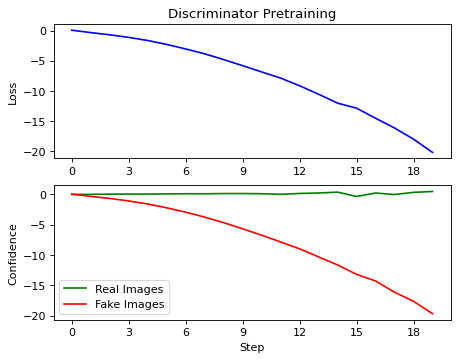

>> Finished Pretraining after 28 seconds
>> Beginning Training

Summary after epoch 1
Training progress: 0%
Time elapsed: 20 seconds
Current Discriminator Loss: -299.
Current Generator Loss: 153.5
Total trained on images: 59904
Total weight adjustments: 117


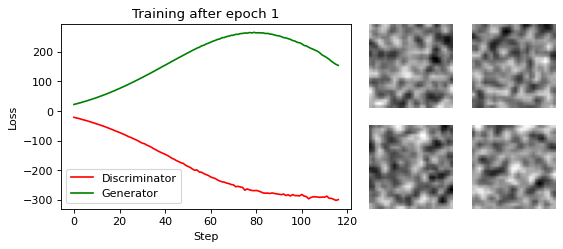

Summary after epoch 10
Training progress: 4%
Time elapsed: 166 seconds
Current Discriminator Loss: -542.
Current Generator Loss: -1574
Total trained on images: 599040
Total weight adjustments: 1170


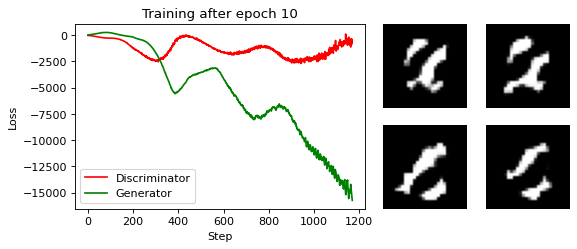

Summary after epoch 20
Training progress: 8%
Time elapsed: 332 seconds
Current Discriminator Loss: 970.1
Current Generator Loss: -1011
Total trained on images: 1198080
Total weight adjustments: 2340


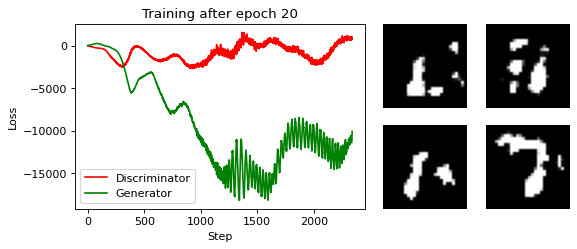

Summary after epoch 30
Training progress: 12%
Time elapsed: 497 seconds
Current Discriminator Loss: 209.2
Current Generator Loss: -1512
Total trained on images: 1797120
Total weight adjustments: 3510


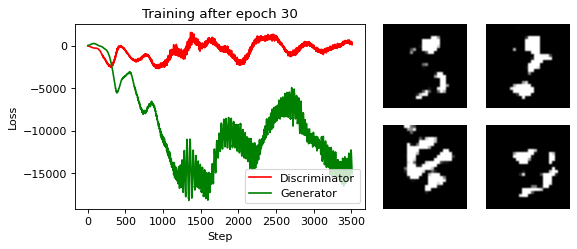

Summary after epoch 40
Training progress: 16%
Time elapsed: 662 seconds
Current Discriminator Loss: -110.
Current Generator Loss: -9753
Total trained on images: 2396160
Total weight adjustments: 4680


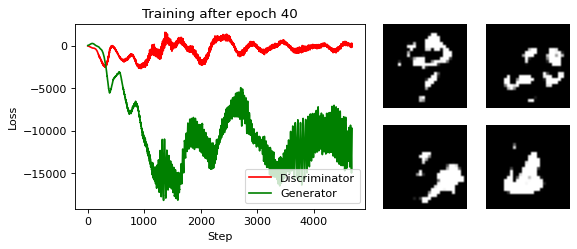

Summary after epoch 50
Training progress: 20%
Time elapsed: 827 seconds
Current Discriminator Loss: -127.
Current Generator Loss: -1263
Total trained on images: 2995200
Total weight adjustments: 5850


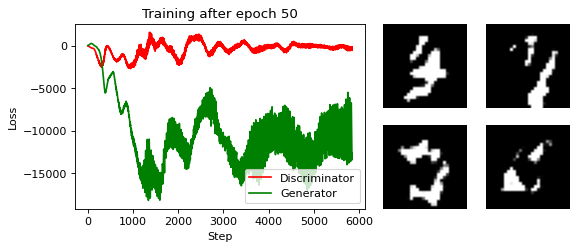

Summary after epoch 60
Training progress: 24%
Time elapsed: 993 seconds
Current Discriminator Loss: -957.
Current Generator Loss: -7705
Total trained on images: 3594240
Total weight adjustments: 7020


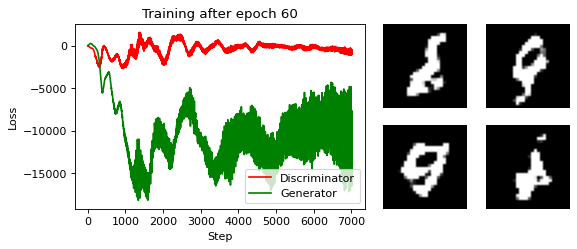

Summary after epoch 70
Training progress: 28%
Time elapsed: 1159 seconds
Current Discriminator Loss: -944.
Current Generator Loss: -1432
Total trained on images: 4193280
Total weight adjustments: 8190


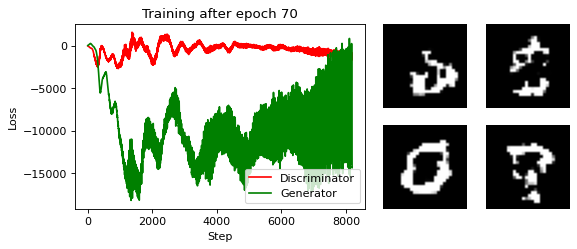

Summary after epoch 80
Training progress: 32%
Time elapsed: 1325 seconds
Current Discriminator Loss: -2599
Current Generator Loss: -5856
Total trained on images: 4792320
Total weight adjustments: 9360


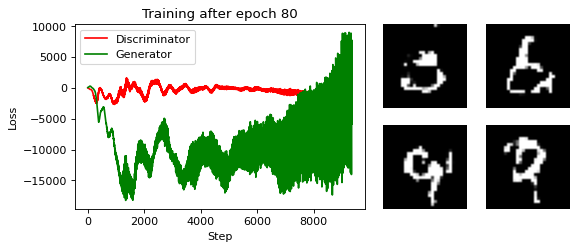

Summary after epoch 90
Training progress: 36%
Time elapsed: 1491 seconds
Current Discriminator Loss: -3691
Current Generator Loss: -7441
Total trained on images: 5391360
Total weight adjustments: 10530


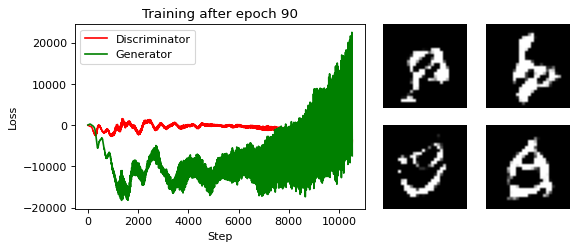

Summary after epoch 100
Training progress: 40%
Time elapsed: 1658 seconds
Current Discriminator Loss: -4278
Current Generator Loss: 25351
Total trained on images: 5990400
Total weight adjustments: 11700


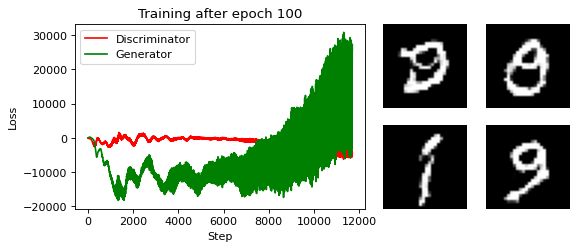

Summary after epoch 110
Training progress: 44%
Time elapsed: 1824 seconds
Current Discriminator Loss: -3540
Current Generator Loss: -2918
Total trained on images: 6589440
Total weight adjustments: 12870


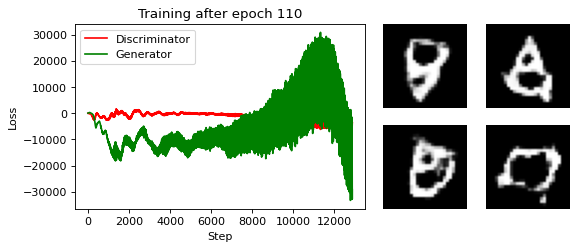

Summary after epoch 120
Training progress: 48%
Time elapsed: 1991 seconds
Current Discriminator Loss: -7040
Current Generator Loss: 4880.
Total trained on images: 7188480
Total weight adjustments: 14040


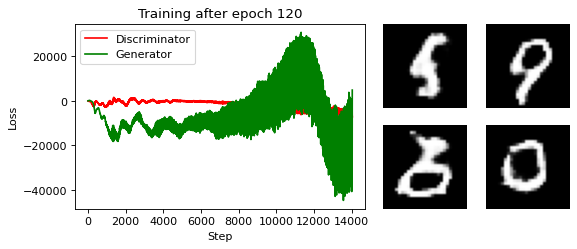

Summary after epoch 130
Training progress: 52%
Time elapsed: 2157 seconds
Current Discriminator Loss: -7912
Current Generator Loss: -1746
Total trained on images: 7787520
Total weight adjustments: 15210


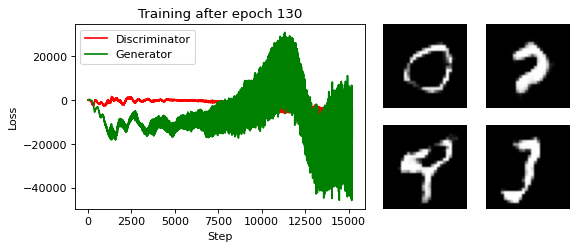

Summary after epoch 140
Training progress: 56%
Time elapsed: 2322 seconds
Current Discriminator Loss: -1260
Current Generator Loss: -5365
Total trained on images: 8386560
Total weight adjustments: 16380


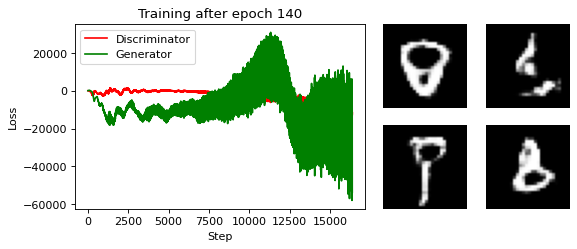

Summary after epoch 150
Training progress: 60%
Time elapsed: 2511 seconds
Current Discriminator Loss: -1307
Current Generator Loss: -2798
Total trained on images: 8985600
Total weight adjustments: 17550


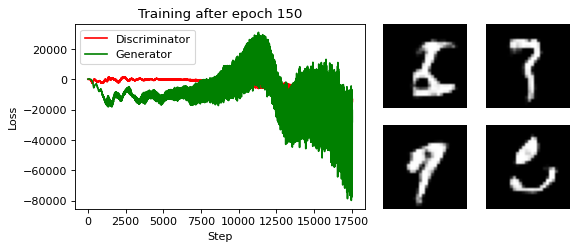

Summary after epoch 160
Training progress: 64%
Time elapsed: 2675 seconds
Current Discriminator Loss: -1751
Current Generator Loss: -9218
Total trained on images: 9584640
Total weight adjustments: 18720


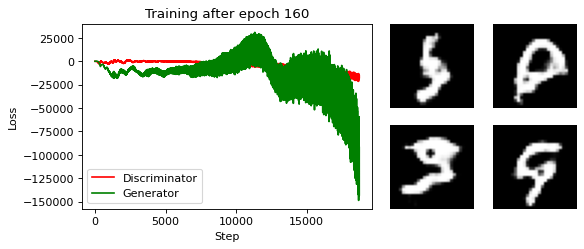

Summary after epoch 170
Training progress: 68%
Time elapsed: 2839 seconds
Current Discriminator Loss: -1580
Current Generator Loss: -1957
Total trained on images: 10183680
Total weight adjustments: 19890


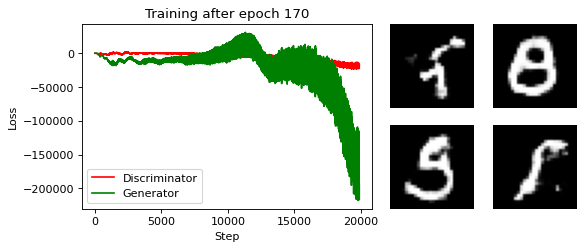

Summary after epoch 180
Training progress: 72%
Time elapsed: 3003 seconds
Current Discriminator Loss: -1850
Current Generator Loss: -1737
Total trained on images: 10782720
Total weight adjustments: 21060


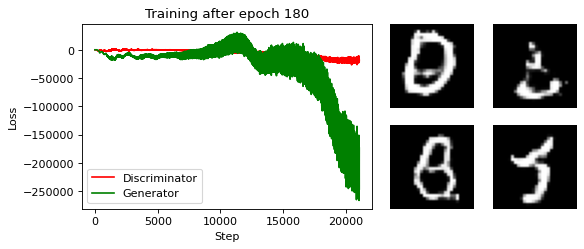

Summary after epoch 190
Training progress: 76%
Time elapsed: 3165 seconds
Current Discriminator Loss: -1259
Current Generator Loss: -2660
Total trained on images: 11381760
Total weight adjustments: 22230


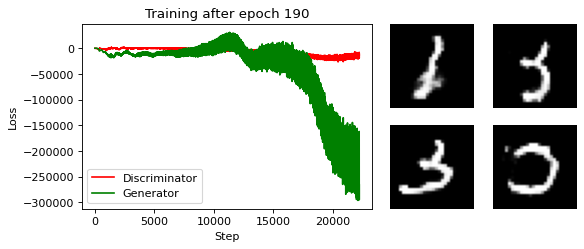

Summary after epoch 200
Training progress: 80%
Time elapsed: 3328 seconds
Current Discriminator Loss: -1436
Current Generator Loss: -2925
Total trained on images: 11980800
Total weight adjustments: 23400


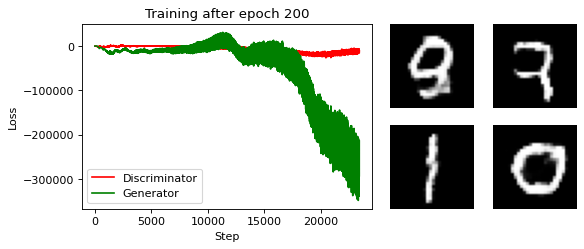

Summary after epoch 210
Training progress: 84%
Time elapsed: 3491 seconds
Current Discriminator Loss: -1170
Current Generator Loss: -2271
Total trained on images: 12579840
Total weight adjustments: 24570


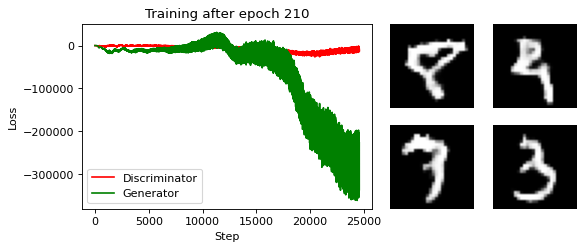

Summary after epoch 220
Training progress: 88%
Time elapsed: 3654 seconds
Current Discriminator Loss: -9555
Current Generator Loss: -2723
Total trained on images: 13178880
Total weight adjustments: 25740


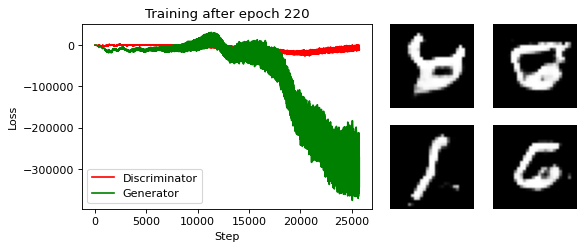

Summary after epoch 230
Training progress: 92%
Time elapsed: 3817 seconds
Current Discriminator Loss: -9711
Current Generator Loss: -3661
Total trained on images: 13777920
Total weight adjustments: 26910


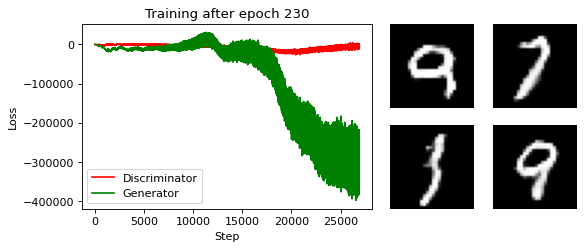

Summary after epoch 240
Training progress: 96%
Time elapsed: 3980 seconds
Current Discriminator Loss: -3398
Current Generator Loss: -2347
Total trained on images: 14376960
Total weight adjustments: 28080


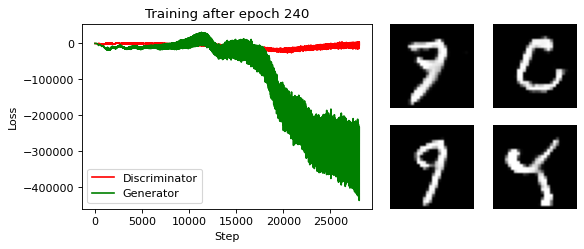

Summary after epoch 250
Training progress: 100%
Time elapsed: 4143 seconds
Current Discriminator Loss: -2330
Current Generator Loss: -4144
Total trained on images: 14976000
Total weight adjustments: 29250


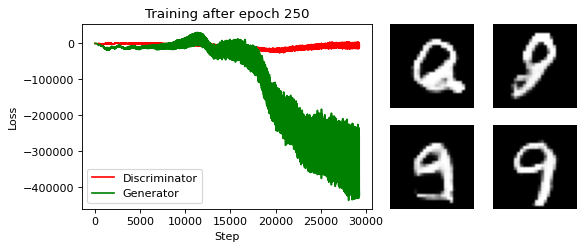

>> Finished Training after 4143 seconds


In [28]:
generator_model = complete_training(generator_learn_rate=0.0001, 
                                    discriminator_learn_rate=0.0001, 
                                    batch_size=512, 
                                    pretraining_steps=20, 
                                    training_epochs=250)

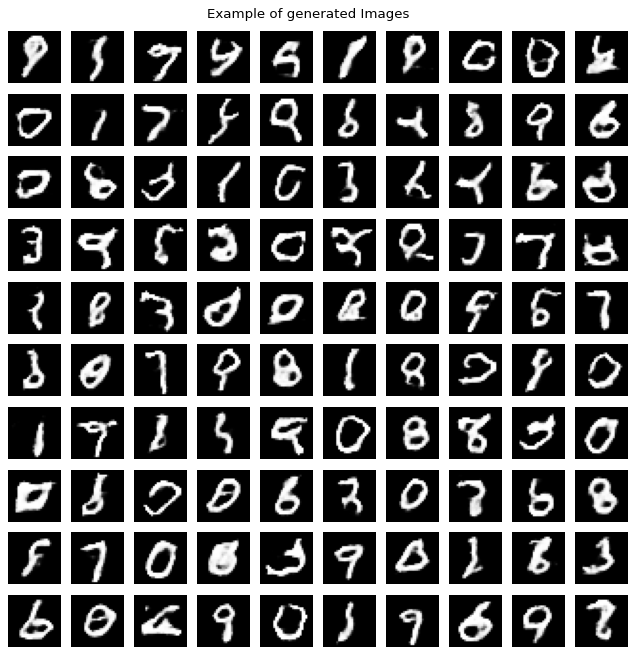

In [29]:
noise = tf.random.normal([100, 100])
fake_img_batch = generator_model(noise, training=False)

fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(10, 10), dpi=80)
plt.suptitle("Example of generated Images", y=0.91)
for i in range(10):
    for j in range(10):
        axes[i][j].imshow(fake_img_batch[i*10+j], cmap="gray")
        axes[i][j].axis('off')

plt.show()

### Conclusion
Creating a WGAN was very similar to creating a normal GAN. Only a few alterations were made in the code. A change of discriminator and generator behavior can definitely be seen in the graphs and output images. The plots of the functions seem to diverge faster together as in the original GAN whilst having a lot of variation along their axis as well.
  
The numbers of the MNIST dataset are recognisable, but not that good in comparison to the original GAN having blurry edges. Probably the model should have been trained for a longer time. Also the clipping of values of the discriminator and experimenting with different alternations of hyperparameters could have improved the results.

## Bibliography

[1] M. Arjovsky, S. Chintala, and L. Bottou. “Wasserstein GAN.” url: https://arxiv.org/pdf/1701.07875.pdf (accessed Apr. 06, 2023).

[2] A. Kristiadi. “Wasserstein GAN implementation in TensorFlow and Pytorch.” 06.04.2023 agustinus.kristia.de. url: https://agustinus.kristia.de/techblog/2017/02/04/wasserstein-gan/ (accessed Apr. 06, 2023).
